In [1]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

In [2]:
# Recopila data de los csv
def get_data(no_plagio, plagio):
    data1 = pd.read_csv(plagio)
    data2 = pd.read_csv(no_plagio)
    data = pd.concat([data1, data2], ignore_index=True)
    return data

In [3]:
# Devuelve los codigos
def get_features(data):
    features = data[['code_java_1', 'code_java_2']]
    return features

In [4]:
# Devuelve los labels (Plagio = 1, No Plagio = 0)
def get_labels(data):
    labels = data[['label']]
    return labels

In [5]:
# Convierte los codigos en secuencias de enteros para que puedan ser procesados
def tokenizar(features_train, features_test):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(features_train['code_java_1'] + features_train['code_java_2'])
    features_train_sequences_code1 = tokenizer.texts_to_sequences(features_train['code_java_1'])
    features_train_sequences_code2 = tokenizer.texts_to_sequences(features_train['code_java_2'])
    features_test_sequences_code1 = tokenizer.texts_to_sequences(features_test['code_java_1'])
    features_test_sequences_code2 = tokenizer.texts_to_sequences(features_test['code_java_2'])
    return features_train_sequences_code1, features_train_sequences_code2, features_test_sequences_code1, features_test_sequences_code2

In [6]:
# Asegurarse de que todas las secuencias tengan la misma longitud
def padding(train_f1, train_f2, test_f1, test_f2):
    max_train_f1 = max(len(seq) for seq in train_f1) 
    max_train_f2 = max(len(seq) for seq in train_f2)
    max_test_f1 = max(len(seq) for seq in test_f1)
    max_test_f2 = max(len(seq) for seq in test_f2)
    max_length = max(max_train_f1, max_train_f2, max_test_f1, max_test_f2)

    features_train_sequences_code1 = pad_sequences(
        train_f1,
        maxlen = max_length
    )

    features_train_sequences_code2 = pad_sequences(
        train_f2,
        maxlen = max_length
    )

    features_test_sequences_code1 = pad_sequences(
        test_f1,
        maxlen = max_length
    )

    features_test_sequences_code2 = pad_sequences(
        test_f2,
        maxlen = max_length
    )
    print(max_length)

    return features_train_sequences_code1, features_train_sequences_code2, features_test_sequences_code1, features_test_sequences_code2

In [8]:
data = get_data(
    'non_plagiarized_java_pairs/non_plagiarized_java_pairs.csv', 'plagiarized_java_pairs.csv'
    )
features = get_features(data)
labels = get_labels(data)

In [9]:
# Split de Train y Test
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [10]:
# Codigos en secuencias de enteros
features_train_sequences_code1, features_train_sequences_code2, features_test_sequences_code1, features_test_sequences_code2 = tokenizar(
    features_train, 
    features_test
)

In [11]:
# Todas las secuencias tengan la misma longitud
features_train_code1, features_train_code2, features_test_code1, features_test_code2 = padding(
    features_train_sequences_code1,
    features_train_sequences_code2,
    features_test_sequences_code1,
    features_test_sequences_code2
)

5199


In [12]:
# Concatenar las secuencias de entrenamiento y prueba
features_train_concatenated = np.concatenate(
    (features_train_code1, features_train_code2), 
    axis=1
)
features_test_concatenated = np.concatenate(
    (features_test_code1, features_test_code2), 
    axis=1
)

In [13]:
# Entrenamiento del modelo XGBoost
xgb_classifier = XGBClassifier()
xgb_classifier.fit(features_train_concatenated, labels_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [14]:
# Predicciones con XGBoost
y_pred_xgb = xgb_classifier.predict(features_test_concatenated)

In [15]:
# Evaluación del modelo XGBoost
accuracy_xgb = accuracy_score(labels_test, y_pred_xgb)
print(f"XGBoost Classifier Accuracy: {accuracy_xgb}")
print(classification_report(labels_test, y_pred_xgb))

XGBoost Classifier Accuracy: 0.9992578456318915
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9421
           1       1.00      0.36      0.53        11

    accuracy                           1.00      9432
   macro avg       1.00      0.68      0.77      9432
weighted avg       1.00      1.00      1.00      9432



Confusion Matrix:
 [[9421    0]
 [   7    4]]


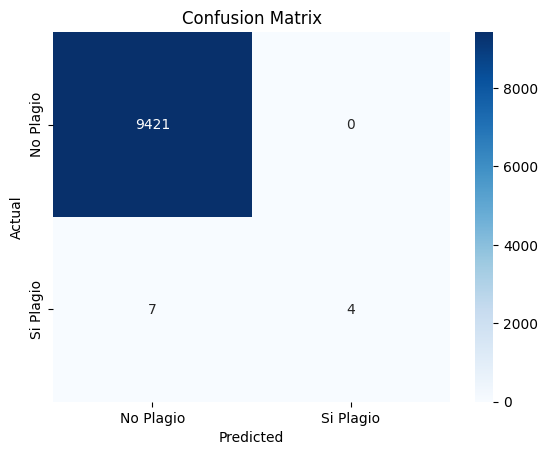

In [17]:
cm = confusion_matrix(labels_test, y_pred_xgb)
print('Confusion Matrix:\n', cm)

# Assuming cm is the confusion matrix
labels = ['No Plagio', 'Si Plagio']  # Replace with your class labels

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels, title, and axis ticks
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)

# Show the plot
plt.show()